In [1]:
# Running nested EM on a mixture of Gaussian mixtures 
# for semisupervised or positive-unlabeled

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from pnuem.empnu import PU_nested_em_opt
from pnuem.Mixture import NMixture, PUMixture
import pnuem.mixtureUtils as mixtureUtils

In [3]:
# Create a dummy dataset
rng = np.random.default_rng()

# positive Gaussian mixtures
mu_pos = np.array([[-2],[1.2]])
mu_neg = np.array([[4],[8]])

sig = np.array([[[1]],[[1]]])
pos = NMixture(mu=mu_pos, sigma=sig, 
               ps=np.array([0.75, 0.25]))
neg = NMixture(mu=mu_neg, sigma=sig, 
               ps=np.array([0.5, 0.5]))

unlabeled = PUMixture(pos,neg, alpha=0.3)

pos_bias = NMixture(mu=mu_pos, sigma=sig, 
                    ps=np.array([0.25, 0.75]))
neg_bias = NMixture(mu=mu_neg, sigma=sig,
                    ps=np.array([0.5, 0.5]))

# Sample points from distributions
labeled_pos = pos_bias.sample_points(5000)
labeled_neg = neg_bias.sample_points(5000)
unlabeled_data = unlabeled.sample_points(10000)

<Axes: >

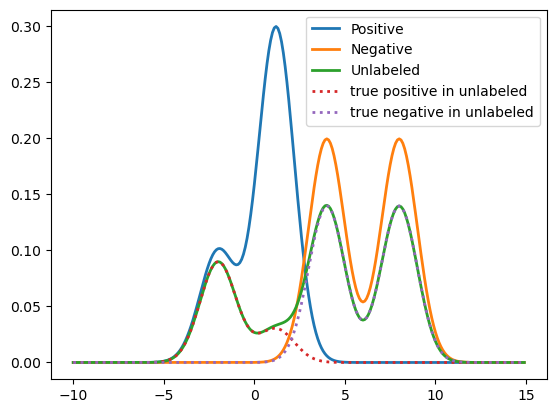

In [4]:
# plotting

xs=np.arange(-10,15,0.1)
sns.lineplot(x=xs, y=pos_bias.points_pdf(xs), linewidth=2, label='Positive')
sns.lineplot(x=xs, y=neg_bias.points_pdf(xs), linewidth=2, label='Negative')

sns.lineplot(x=xs, y=unlabeled.points_pdf(xs), linewidth=2, label='Unlabeled')

sns.lineplot(x=xs, y=unlabeled.alpha*unlabeled.pos.points_pdf(xs), 
             linewidth=2, linestyle=':', label='true positive in unlabeled')
sns.lineplot(x=xs, y=(1-unlabeled.alpha)*unlabeled.neg.points_pdf(xs), 
             linewidth=2, linestyle=':', label='true negative in unlabeled')

In [5]:
# Estimate model parameters

Kfit = [2, 2]  # number of components to use in parameter estimation

alphas, w, w_l, sg, mu, lls = PU_nested_em_opt(unlabeled_data, [labeled_pos, labeled_neg],
                                               Kfit, max_steps=5000)

In [6]:
# Qualitatively evaluate estimates

<Axes: >

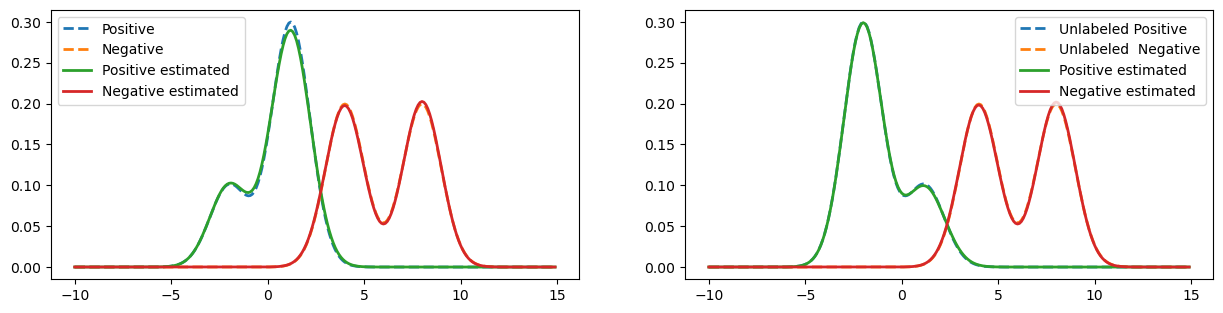

In [7]:
# plotting
pos_bias_estimated = NMixture(mu=mu[0], sigma=sg[0], ps=w_l[0])
neg_bias_estimated = NMixture(mu=mu[1], sigma=sg[1], ps=w_l[1])
pos_estimated = NMixture(mu=mu[0], sigma=sg[0], ps=w[0])
neg_estimated = NMixture(mu=mu[1], sigma=sg[1], ps=w[1])

xs=np.arange(-10,15,0.1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3.5))
sns.lineplot(x=xs, y=pos_bias.points_pdf(xs), linewidth=2, linestyle='--', label='Positive', ax=axs[0])
sns.lineplot(x=xs, y=neg_bias.points_pdf(xs), linewidth=2, linestyle='--', label='Negative', ax=axs[0])

sns.lineplot(x=xs, y=pos_bias_estimated.points_pdf(xs), linewidth=2, label='Positive estimated', ax=axs[0])
sns.lineplot(x=xs, y=neg_bias_estimated.points_pdf(xs), linewidth=2, label='Negative estimated', ax=axs[0])


sns.lineplot(x=xs, y=pos.points_pdf(xs), linewidth=2, linestyle='--', label='Unlabeled Positive', ax=axs[1])
sns.lineplot(x=xs, y=neg.points_pdf(xs), linewidth=2, linestyle='--', label='Unlabeled  Negative', ax=axs[1])

sns.lineplot(x=xs, y=pos_estimated.points_pdf(xs), linewidth=2, label='Positive estimated', ax=axs[1])
sns.lineplot(x=xs, y=neg_estimated.points_pdf(xs), linewidth=2, label='Negative estimated', ax=axs[1])


In [8]:



print(f'Estimated alpha={alphas[0]:.4f}. Actual alpha={unlabeled.alpha:.4f}')

print('Note: Order or components may be reverse')
print('Distribution means')
print(f'\tPositive estimated mus={np.array2string(mu[0])}. Actual mus={np.array2string(pos.mu, precision=4)}')

print(f'\tNegative estimated mus={np.array2string(mu[1])}. Actual mus={np.array2string(neg.mu, precision=4)}')

print('Mixing proportions (Unlabeled data)')
print(f'\tPositive estimated ps={np.array2string(w[0])}. Actual ps={np.array2string(pos.ps, precision=4)}')
print(f'\tNegative estimated ps={np.array2string(w[1])}. Actual ps={np.array2string(neg.ps, precision=4)}')

print('Mixing proportions (Labeled data)')
print(f'\tPositive estimated ps={np.array2string(w_l[0])}. Actual ps={np.array2string(pos_bias.ps, precision=4)}')
print(f'\tNegative estimated ps={np.array2string(w_l[1])}. Actual ps={np.array2string(neg_bias.ps, precision=4)}')

Estimated alpha=0.3006. Actual alpha=0.3000
Note: Order or components may be reverse
Distribution means
	Positive estimated mus=[[-2.00123438]
 [ 1.19160419]]. Actual mus=[[-2. ]
 [ 1.2]]
	Negative estimated mus=[[8.00741876]
 [3.99081551]]. Actual mus=[[4]
 [8]]
Mixing proportions (Unlabeled data)
	Positive estimated ps=[0.74692604 0.25307396]. Actual ps=[0.75 0.25]
	Negative estimated ps=[0.50006019 0.49993981]. Actual ps=[0.5 0.5]
Mixing proportions (Labeled data)
	Positive estimated ps=[0.25053979 0.74946021]. Actual ps=[0.25 0.75]
	Negative estimated ps=[0.50172583 0.49827417]. Actual ps=[0.5 0.5]


In [9]:
print('AUC between labeled and unlabeled positives')
print(f'Estimated:\t{mixtureUtils.auc(pos_estimated, pos_bias_estimated):.4f}')
print(f'Actual:\t\t{mixtureUtils.auc(pos, pos_bias):.4f}')
print('')
print('AUC between labeled and unlabeled negatives')
print(f'Estimated:\t{mixtureUtils.auc(neg_estimated, neg_bias_estimated):.4f}')
print(f'Actual:\t\t{mixtureUtils.auc(neg, neg_bias):.4f}')

AUC between labeled and unlabeled positives
Estimated:	0.7413
Actual:		0.7465

AUC between labeled and unlabeled negatives
Estimated:	0.5003
Actual:		0.5000


## Fit distributions with a different number of components 

In [10]:
# Estimate model parameters

Kfit = [2, 1]  # number of components to use in parameter estimation

alphas, w, w_l, sg, mu, lls = PU_nested_em_opt(unlabeled_data, [labeled_pos, labeled_neg],
                                               Kfit, max_steps=5000)

Text(0.5, 1.0, 'Unbias (unlabeled) data')

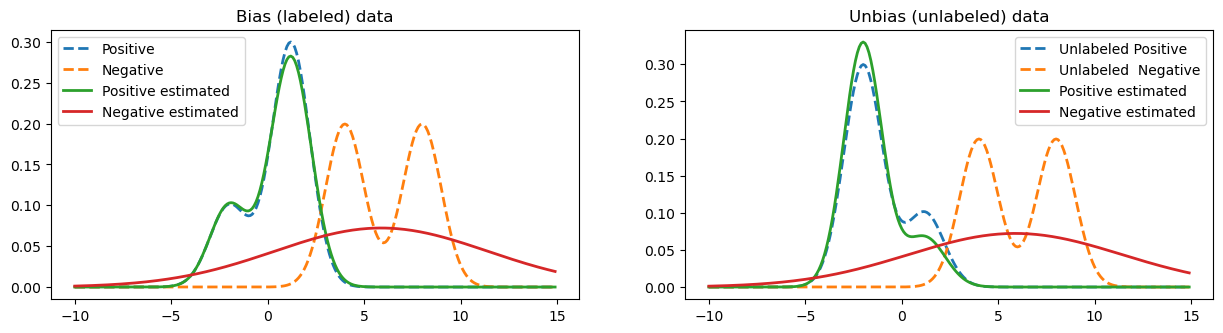

In [11]:
# plotting
pos_bias_estimated = NMixture(mu=mu[0], sigma=sg[0], ps=w_l[0])
neg_bias_estimated = NMixture(mu=mu[1], sigma=sg[1], ps=w_l[1])
pos_estimated = NMixture(mu=mu[0], sigma=sg[0], ps=w[0])
neg_estimated = NMixture(mu=mu[1], sigma=sg[1], ps=w[1])

xs=np.arange(-10,15,0.1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3.5))
sns.lineplot(x=xs, y=pos_bias.points_pdf(xs), linewidth=2, linestyle='--', label='Positive', ax=axs[0])
sns.lineplot(x=xs, y=neg_bias.points_pdf(xs), linewidth=2, linestyle='--', label='Negative', ax=axs[0])

sns.lineplot(x=xs, y=pos_bias_estimated.points_pdf(xs), linewidth=2, label='Positive estimated', ax=axs[0])
sns.lineplot(x=xs, y=neg_bias_estimated.points_pdf(xs), linewidth=2, label='Negative estimated', ax=axs[0])
axs[0].set_title('Bias (labeled) data')


sns.lineplot(x=xs, y=pos.points_pdf(xs), linewidth=2, linestyle='--', label='Unlabeled Positive', ax=axs[1])
sns.lineplot(x=xs, y=neg.points_pdf(xs), linewidth=2, linestyle='--', label='Unlabeled  Negative', ax=axs[1])

sns.lineplot(x=xs, y=pos_estimated.points_pdf(xs), linewidth=2, label='Positive estimated', ax=axs[1])
sns.lineplot(x=xs, y=neg_estimated.points_pdf(xs), linewidth=2, label='Negative estimated', ax=axs[1])
axs[1].set_title('Unbias (unlabeled) data')